In [1]:
import matplotlib.pyplot as plt
import numpy as np
from astropy.io import fits
from glob import glob
import os
from astropy.visualization import ZScaleInterval, ImageNormalize, LogStretch, AsymmetricPercentileInterval
import h5py 
from astropy.nddata import CCDData
import astropy.constants as const
from PIL import Image
from datetime import datetime, timedelta
from ccdproc import ImageFileCollection
import pandas as pd
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from matplotlib.ticker import AutoLocator, AutoMinorLocator, FixedLocator, FixedFormatter, LogLocator, StrMethodFormatter
from matplotlib import patches
from matplotlib.markers import MarkerStyle
import cmcrameri.cm as cmcm
import cmasher as cmr
from scipy import ndimage
from scipy.io import readsav
import copy
from juanfit import SpectrumFitSingle, SpectrumFitRow, gaussian

In [9]:
green_path = "../../src/EclipseSpectra2017/MikesData_l1/Green/"
red_path = "../../src/EclipseSpectra2017/MikesData_l1/Red/"

green_fname = "TotalitySequenceGreen_22711(2)_l1.fit"
red_fname = "TotalitySequenceRed_7717(2)_l1.fit"

In [10]:
green_frame = CCDData.read(os.path.join(green_path, green_fname),unit="adu")
red_frame = CCDData.read(os.path.join(red_path, red_fname),unit="adu")
green_image = green_frame.data/green_frame.header["EXPTIME"]
red_image = red_frame.data/red_frame.header["EXPTIME"]
green_wavelength = CCDData.read(os.path.join(green_path,green_fname),hdu=1,unit="angstrom").data
red_wavelength = CCDData.read(os.path.join(red_path,red_fname),hdu=1,unit="angstrom").data
green_xpixel_array = np.arange(green_frame.header["XWS"],green_frame.header["XWS"]+green_frame.header["NAXIS1"])
red_xpixel_array = np.arange(red_frame.header["XWS"],red_frame.header["XWS"]+red_frame.header["NAXIS1"])

In [5]:
norm_green = ImageNormalize(green_image,stretch=LogStretch())
norm_red = ImageNormalize(red_image,stretch=LogStretch())

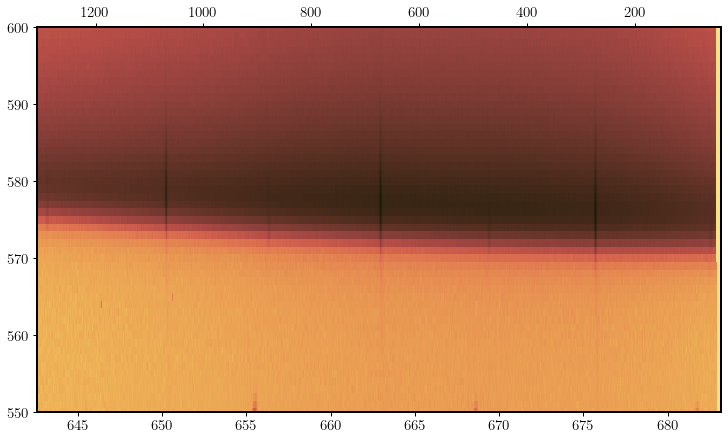

In [15]:
fig, ax = plt.subplots(figsize=(10,6),constrained_layout=True)
im_red = ax.pcolormesh(red_wavelength/50./10.,np.arange(red_frame.header["NAXIS2"]) + red_frame.header["YWS"],
                        red_image,cmap=cmcm.lajolla,norm=norm_red,shading='auto',rasterized=True)

ax_2 = ax.twiny()
ax_2.set_xlim((red_frame.header["NAXIS1"]-0.5,red_frame.header["XWS"]-0.5))
ax.set_ylim(550,600)
ax.tick_params(labelsize=15)
ax_2.tick_params(labelsize=15)

In [18]:
Hbeta_wvl = 486.135
HeI_D3_wvl = 587.5621
Halpha_wvl = 656.279

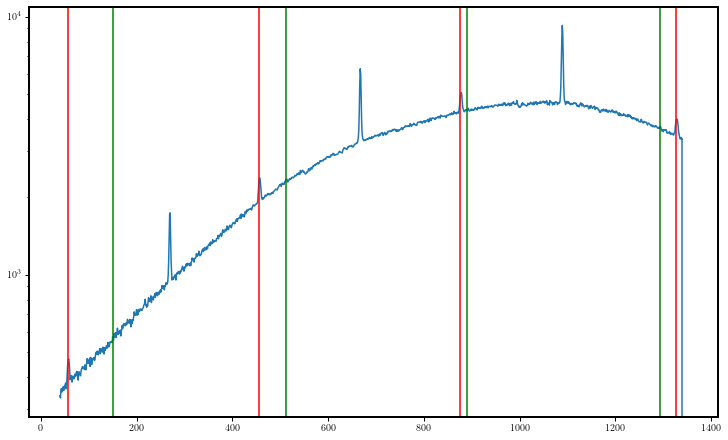

In [16]:
fig, ax = plt.subplots(figsize=(10,6),constrained_layout=True)
ax.plot(red_xpixel_array,np.average(red_image[572 - red_frame.header["YWS"]:576 - red_frame.header["YWS"],:],axis=0))
ax.set_yscale("log")

for x_pos_ in (56.632, 455.637, 876.324, 1326.913):
    ax.axvline(x_pos_,color="red")

for x_pos_ in (151.42, 511.91, 890.45, 1293.00 ):
    ax.axvline(x_pos_,color="green")

Pixel diff: 1.30 +/- 0.23 
 Wavelength diff: 0.027 +/- 0.008 nm 12.5 +/- 3.7 km/s


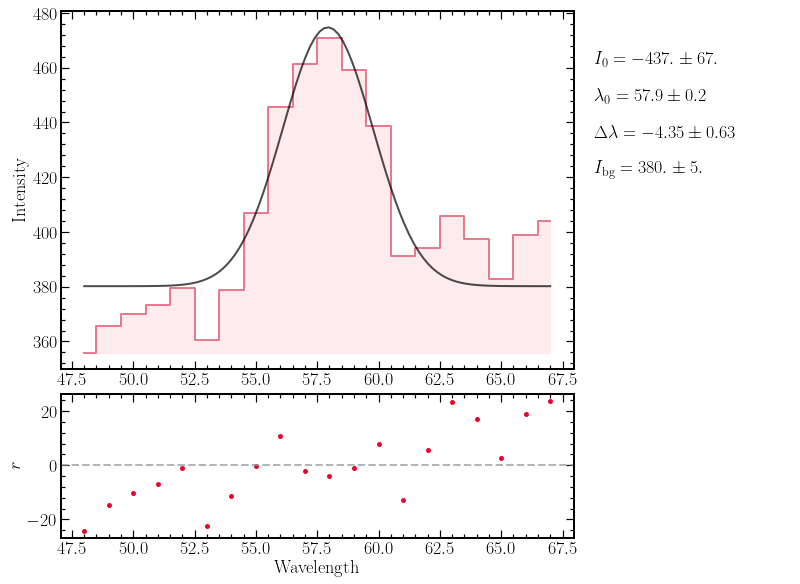

In [19]:
Halpha_slice_49 = slice(48 - red_frame.header["XWS"],68 - red_frame.header["XWS"])
Halpha_model_49 = SpectrumFitSingle(data=np.average(red_image[572 - red_frame.header["YWS"]:576 - red_frame.header["YWS"],
                    Halpha_slice_49],axis=0), 
                    wvl=red_xpixel_array[Halpha_slice_49],line_number=1,line_wvl_init=[57.5],
                    int_max_init=50000,fwhm_init=[1],same_width=False)
Halpha_model_49.run_lse(absolute_sigma=False)
ax = Halpha_model_49.plot(plot_fit=True)
Halpha_pixel_diff_49 = Halpha_model_49.line_wvl_fit[0] - 56.632
Halpha_pixel_diff_49_err = np.sqrt(Halpha_model_49.line_wvl_err[0]**2 + 0.004**2)


Halpha_wvl_diff_49 = np.interp(Halpha_model_49.line_wvl_fit[0], red_xpixel_array, red_wavelength/49./10.) - Halpha_wvl
Halpha_wvl_diff_49_err = np.abs(np.interp(Halpha_model_49.line_wvl_fit[0] + Halpha_model_49.line_wvl_err[0], 
                    red_xpixel_array, red_wavelength/49./10.) - Halpha_wvl - Halpha_wvl_diff_49)

Halpha_vlos_diff_49 = Halpha_wvl_diff_49/Halpha_wvl*3e5
Halpha_vlos_diff_49_err = Halpha_wvl_diff_49_err/Halpha_wvl*3e5

print("Pixel diff: {:.2f} +/- {:.2f} \n Wavelength diff: {:.3f} +/- {:.3f} nm {:.1f} +/- {:.1f} km/s".format(Halpha_pixel_diff_49, Halpha_pixel_diff_49_err,
                                                Halpha_wvl_diff_49,Halpha_wvl_diff_49_err, Halpha_vlos_diff_49,Halpha_vlos_diff_49_err))

Pixel diff: 1.49 +/- 0.15 
 Wavelength diff: 0.058 +/- 0.005 nm 26.7 +/- 2.2 km/s


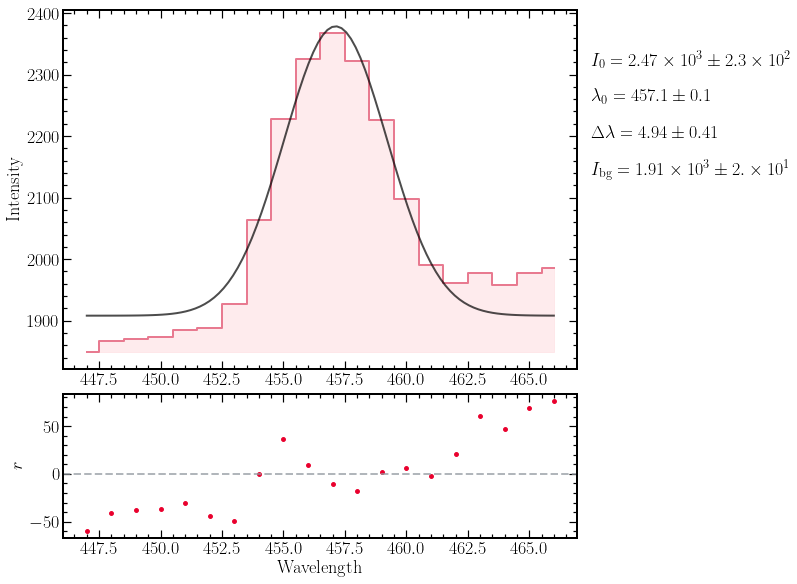

In [20]:
Halpha_slice_50 = slice(447 - red_frame.header["XWS"],467 - red_frame.header["XWS"])
Halpha_model_50 = SpectrumFitSingle(data=np.average(red_image[572 - red_frame.header["YWS"]:576 - red_frame.header["YWS"],
                    Halpha_slice_50],axis=0), 
                    wvl=red_xpixel_array[Halpha_slice_50],line_number=1,line_wvl_init=[456.6],
                    int_max_init=40000,fwhm_init=[1],same_width=False)
Halpha_model_50.run_lse(absolute_sigma=False)
ax = Halpha_model_50.plot(plot_fit=True)
Halpha_pixel_diff_50 = Halpha_model_50.line_wvl_fit[0] - 455.637
Halpha_pixel_diff_50_err = np.sqrt(Halpha_model_50.line_wvl_err[0]**2 + 0.004**2)

Halpha_wvl_diff_50 = np.interp(Halpha_model_50.line_wvl_fit[0], red_xpixel_array, red_wavelength/50./10.) - Halpha_wvl
Halpha_wvl_diff_50_err = np.abs(np.interp(Halpha_model_50.line_wvl_fit[0] + Halpha_model_50.line_wvl_err[0], 
                    red_xpixel_array, red_wavelength/50./10.) - Halpha_wvl - Halpha_wvl_diff_50)

Halpha_vlos_diff_50 = Halpha_wvl_diff_50/Halpha_wvl*3e5
Halpha_vlos_diff_50_err = Halpha_wvl_diff_50_err/Halpha_wvl*3e5

print("Pixel diff: {:.2f} +/- {:.2f} \n Wavelength diff: {:.3f} +/- {:.3f} nm {:.1f} +/- {:.1f} km/s".format(Halpha_pixel_diff_50, Halpha_pixel_diff_50_err,
                                                Halpha_wvl_diff_50,Halpha_wvl_diff_50_err, Halpha_vlos_diff_50,Halpha_vlos_diff_50_err))

Pixel diff: 1.32 +/- 0.08 
 Wavelength diff: 0.021 +/- 0.002 nm 9.8 +/- 1.1 km/s


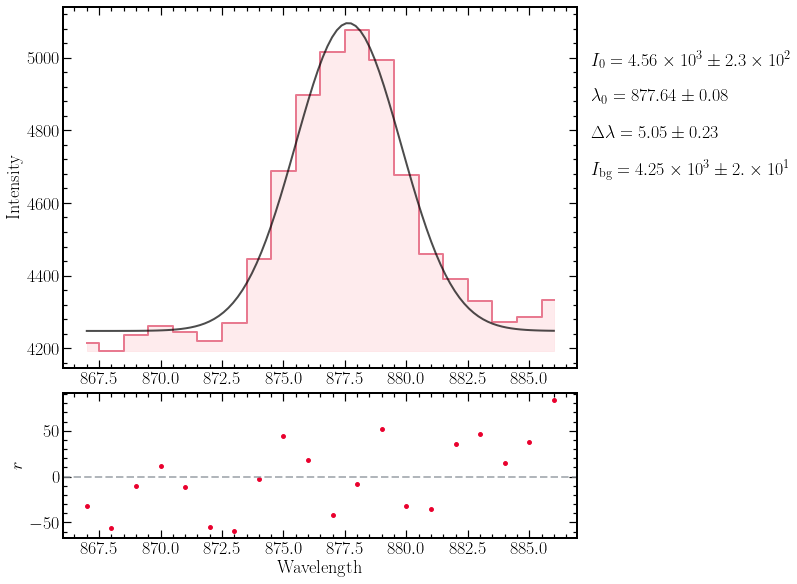

In [21]:
Halpha_slice_51 = slice(867 - red_frame.header["XWS"],887 - red_frame.header["XWS"])
Halpha_model_51 = SpectrumFitSingle(data=np.average(red_image[572 - red_frame.header["YWS"]:576 - red_frame.header["YWS"],
                    Halpha_slice_51],axis=0), 
                    wvl=red_xpixel_array[Halpha_slice_51],line_number=1,line_wvl_init=[877.3],
                    int_max_init=40000,fwhm_init=[1],same_width=False)
Halpha_model_51.run_lse(absolute_sigma=False)
ax = Halpha_model_51.plot(plot_fit=True)
Halpha_pixel_diff_51 = Halpha_model_51.line_wvl_fit[0] - 876.324
Halpha_pixel_diff_51_err = np.sqrt(Halpha_model_51.line_wvl_err[0]**2 + 0.006**2)

Halpha_wvl_diff_51 = np.interp(Halpha_model_51.line_wvl_fit[0], red_xpixel_array, red_wavelength/51./10.) - Halpha_wvl
Halpha_wvl_diff_51_err = np.abs(np.interp(Halpha_model_51.line_wvl_fit[0] + Halpha_model_51.line_wvl_err[0], 
                    red_xpixel_array, red_wavelength/51./10.) - Halpha_wvl - Halpha_wvl_diff_51)

Halpha_vlos_diff_51 = Halpha_wvl_diff_51/Halpha_wvl*3e5
Halpha_vlos_diff_51_err = Halpha_wvl_diff_51_err/Halpha_wvl*3e5

print("Pixel diff: {:.2f} +/- {:.2f} \n Wavelength diff: {:.3f} +/- {:.3f} nm {:.1f} +/- {:.1f} km/s".format(Halpha_pixel_diff_51, Halpha_pixel_diff_51_err,
                                                Halpha_wvl_diff_51,Halpha_wvl_diff_51_err, Halpha_vlos_diff_51,Halpha_vlos_diff_51_err))

Pixel diff: 1.07 +/- 0.15 
 Wavelength diff: 0.035 +/- 0.004 nm 16.0 +/- 1.8 km/s


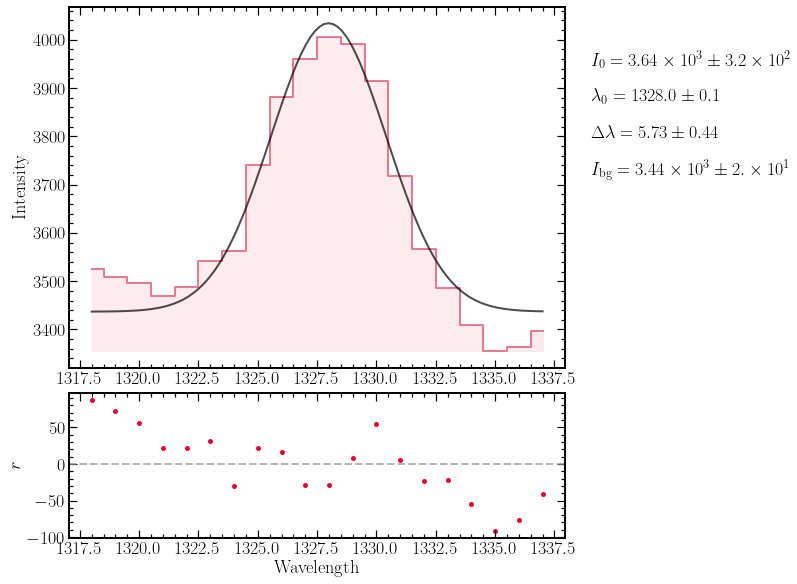

In [22]:
Halpha_slice_52 = slice(1318 - red_frame.header["XWS"],1338 - red_frame.header["XWS"])
Halpha_model_52 = SpectrumFitSingle(data=np.average(red_image[572 - red_frame.header["YWS"]:576 - red_frame.header["YWS"],
                    Halpha_slice_52],axis=0), 
                    wvl=red_xpixel_array[Halpha_slice_52],line_number=1,line_wvl_init=[1327.9],
                    int_max_init=40000,fwhm_init=[1],same_width=False)
Halpha_model_52.run_lse(absolute_sigma=False)
ax = Halpha_model_52.plot(plot_fit=True)
Halpha_pixel_diff_52 = Halpha_model_52.line_wvl_fit[0] - 1326.913
Halpha_pixel_diff_52_err = np.sqrt(Halpha_model_52.line_wvl_err[0]**2 + 0.005**2)

Halpha_wvl_diff_52 = np.interp(Halpha_model_52.line_wvl_fit[0], red_xpixel_array, red_wavelength/52./10.) - Halpha_wvl
Halpha_wvl_diff_52_err = np.abs(np.interp(Halpha_model_52.line_wvl_fit[0] + Halpha_model_52.line_wvl_err[0], 
                    red_xpixel_array, red_wavelength/52./10.) - Halpha_wvl - Halpha_wvl_diff_52)

Halpha_vlos_diff_52 = Halpha_wvl_diff_52/Halpha_wvl*3e5
Halpha_vlos_diff_52_err = Halpha_wvl_diff_52_err/Halpha_wvl*3e5

print("Pixel diff: {:.2f} +/- {:.2f} \n Wavelength diff: {:.3f} +/- {:.3f} nm {:.1f} +/- {:.1f} km/s".format(Halpha_pixel_diff_52, Halpha_pixel_diff_52_err,
                                                Halpha_wvl_diff_52,Halpha_wvl_diff_52_err, Halpha_vlos_diff_52,Halpha_vlos_diff_52_err))